# Load data
<https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)>

In [1]:
import pandas as pd
from data.utils import split_data

In [2]:
# Feature names
columns = [
    'Checking Status', 'Duration', 'Credit History', 'Purpose',
    'Credit Amount', 'Savings Account/Bonds', 'Employment Since',
    'Installment Rate', 'Personal Status', 'Debtors/Guarantors',
    'Residence Duration', 'Property Type', 'Age',
    'Other Installment Plans', 'Housing Ownership',
    'Number Existing Credits', 'Job', 'Number Liable', 'Telephone',
    'Foreign Worker', 'Good Customer'
]
categorical_columns = [
    'Checking Status', 'Credit History', 'Purpose', 'Credit Amount',
    'Savings Account/Bonds', 'Employment Since', 'Personal Status',
    'Debtors/Guarantors', 'Property Type', 'Other Installment Plans',
    'Housing Ownership', 'Job', 'Telephone', 'Foreign Worker'
]
categorical_inds = [columns.index(col) for col in categorical_columns]

# Load data
df = pd.read_table('data/german.data', sep=' ', header=None,
                   index_col=None, names=columns)

# Make labels 0/1
df['Good Customer'] = df['Good Customer'] - 1

# Names
feature_names = columns[:-1]

In [3]:
# Split data
train, val, test = split_data(df.values, seed=1,
                              val_portion=0.1,
                              test_portion=0.1)
Y_train = train[:, -1].copy().astype(int)
Y_val = val[:, -1].copy().astype(int)
Y_test = test[:, -1].copy().astype(int)
train = train[:, :-1].copy()
val = val[:, :-1].copy()
test = test[:, :-1].copy()

# Train model

In [4]:
import numpy as np
from sklearn.metrics import log_loss
from catboost import CatBoostClassifier

In [5]:
model = CatBoostClassifier(iterations=50,
                           learning_rate=0.3,
                           depth=3)

model = model.fit(train, Y_train, categorical_inds, eval_set=(val, Y_val),
                  verbose=False)

In [6]:
# Calculate performance
p = np.array([np.sum(Y_train == i) for i in np.unique(Y_train)]) / len(Y_train)
base_ce = log_loss(Y_test.astype(int), p[np.newaxis].repeat(len(test), 0))
ce = log_loss(Y_test.astype(int), model.predict_proba(test))

print('Base rate cross entropy = {:.3f}'.format(base_ce))
print('Model cross entropy = {:.3f}'.format(ce))

Base rate cross entropy = 0.611
Model cross entropy = 0.506


# Calculate feature importance

In [7]:
import sage

In [8]:
# Setup and calculate
imputer = sage.MarginalImputer(test, samples=512)
sampler = sage.PermutationSampler(model, imputer, 'cross entropy')
sage_values = sampler(test, Y_test)

Estimating convergence time
batch size = batch * samples = 262144


StdDev Ratio = 0.2526 (Converge at 0.0500)
StdDev Ratio = 0.2012 (Converge at 0.0500)
StdDev Ratio = 0.1268 (Converge at 0.0500)
StdDev Ratio = 0.1003 (Converge at 0.0500)
StdDev Ratio = 0.0947 (Converge at 0.0500)
StdDev Ratio = 0.0864 (Converge at 0.0500)
StdDev Ratio = 0.0788 (Converge at 0.0500)
StdDev Ratio = 0.0753 (Converge at 0.0500)
StdDev Ratio = 0.0715 (Converge at 0.0500)
StdDev Ratio = 0.0684 (Converge at 0.0500)
StdDev Ratio = 0.0675 (Converge at 0.0500)
StdDev Ratio = 0.0636 (Converge at 0.0500)
StdDev Ratio = 0.0609 (Converge at 0.0500)
StdDev Ratio = 0.0606 (Converge at 0.0500)
StdDev Ratio = 0.0592 (Converge at 0.0500)
StdDev Ratio = 0.0573 (Converge at 0.0500)
StdDev Ratio = 0.0558 (Converge at 0.0500)
StdDev Ratio = 0.0533 (Converge at 0.0500)
StdDev Ratio = 0.0527 (Converge at 0.0500)
StdDev Ratio = 0.0509 (Converge at 0.0500)
StdDev Ratio = 0.0508 (Converge at 0.0500)
StdDev Ratio = 0.0501 (Converge at 0.0500)
StdDev Ratio = 0.0498 (Converge at 0.0500)
Detected co

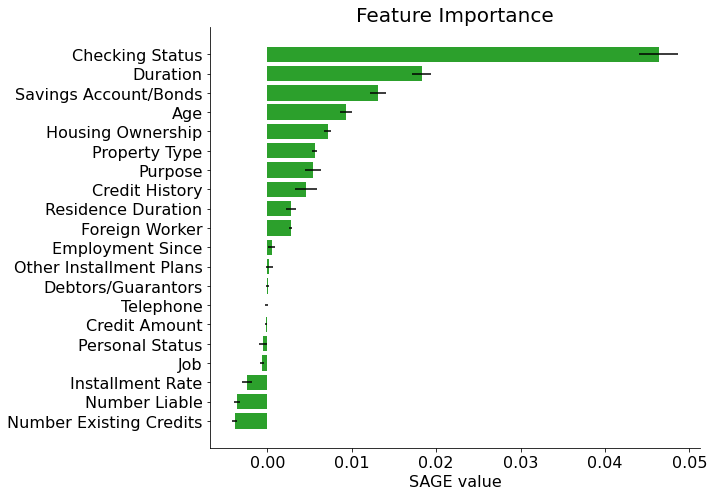

In [9]:
# Plot results
sage_values.plot(feature_names)